In [32]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd")
import json_tricks as json
import warnings

import matplotlib as mpl

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk

import config

import utils
import metrics
import time
import plot
import svgd
import stein
import kernels
from svgd import SVGD

from jax.experimental import optimizers

rkey = random.PRNGKey(0)
basedir = "/home/lauro/code/msc-thesis/svgd/"

## Summary

In [33]:
def get_data(logdir):
    """Take directory with run results and return a Pandas DataFrame with the relevant hparams plus metrics.
    Returns:
    * frame: a pandas dataframe with config hparams and metrics
    * data: a list of dicts with data collected during runs"""
    cfgs = []
    rundata = []
    metrics = []
    sweep_metaconfigs = []
    base_metaconfigs = []
    for rundir in os.listdir(logdir):
        if os.path.isdir(os.path.join(logdir, rundir)):
            configfile, datafile, metricfile = [logdir + rundir + f for f in ["/config.json", "/rundata.json", "/metrics.json"]]
            try:
                with open(configfile, "r") as f:
                    cfgs.append(json.load(f))
                with open(datafile, "r") as f:
                    rundata.append(json.load(f))
                with open(metricfile, "r") as f:
                    metrics.append(json.load(f))
            except FileNotFoundError:
                warnings.warn(f"Failed loading one or more files from {rundir}.")
        else:
            with open(logdir + rundir, "r") as f:
                base, sweep_config = json.load(f)
                sweep_metaconfigs.append(sweep_config)
                base_metaconfigs.append(base)
     
    # process data
    cfgs_flat = [utils.flatten_dict(c) for c in cfgs]
#     for c in cfgs_flat:
#         c["optimizer_svgd_args"] = onp.squeeze(c["optimizer_svgd_args"])
#         c["optimizer_ksd_args"] = onp.squeeze(c["optimizer_ksd_args"])
    
    
    configs_df = pd.DataFrame(cfgs_flat)
#     configs_df.rename(columns={"optimizer_svgd_args": "lr_svgd", "optimizer_ksd_args": "lr_ksd"}, inplace=True)
    
    metrics_df = pd.DataFrame(metrics)
    all_df = pd.concat([metrics_df, configs_df], axis=1)
    all_df["encoder_layers"] = all_df.encoder_layers.astype('str').astype('category')
    all_df["decoder_layers"] = all_df.decoder_layers.astype('str').astype('category')
    all_df.target_args       = all_df.target_args.astype('str').astype("category")
    all_df["train"] = all_df.train.astype('category')
    
    # to numeric
    all_df.lr_ksd  = pd.to_numeric(all_df.lr_ksd.astype("str"), errors="coerce")
    all_df.lr_svgd = pd.to_numeric(all_df.lr_svgd.astype("str"), errors="coerce")
    
    
    if all_df.isnull().values.any():
        rows_with_nans = all_df.shape[0] - all_df.dropna().shape[0]
        warnings.warn(f"Detected NaNs in dataframe. {rows_with_nans} / {all_df.shape[0]} rows include at least one NaN or inf. Dropping all rows with nonfinite values.")
#         all_df = all_df.dropna()

    return all_df, rundata, cfgs, sweep_metaconfigs, base_metaconfigs

In [3]:
ls ../../leonhard-runs/

2-dim/  2-dim-banana/  aug-4/  aug-5/


In [4]:
rundir = basedir + "leonhard-runs/2-dim/"
frame, rundata, configs, sweep_metaconfigs, base_metaconfigs = get_data(rundir)

<ipython-input-2-d6a638226f18>:53: UserWarning: Detected NaNs in dataframe. 75 / 434 rows include at least one NaN or inf. Dropping all rows with nonfinite values.
  warnings.warn(f"Detected NaNs in dataframe. {rows_with_nans} / {all_df.shape[0]} rows include at least one NaN or inf. Dropping all rows with nonfinite values.")


In [34]:
relevant = ["se_mean", "se_var", "ksd", "emd"] + ["lr_ksd", "lr_svgd", "svgd_steps", "encoder_layers", "ksd_steps", "train", "lambda_reg", "target_args", "minimize_ksd_variance"]
f = frame[relevant]
# f

In [35]:
f.ksd_steps.describe()

count    364.000000
mean       7.500000
std        2.503441
min        5.000000
25%        5.000000
50%        7.500000
75%       10.000000
max       10.000000
Name: ksd_steps, dtype: float64

In [7]:
f.emd.describe()

count    434.000000
mean       9.427546
std        9.008477
min        0.000000
25%        3.937244
50%       10.163977
75%       10.913421
max       89.674797
Name: emd, dtype: float64

In [8]:
f.se_mean.describe()

count    429.000000
mean      41.681667
std       59.549122
min        0.000307
25%        1.853115
50%       49.993538
75%       58.371399
max      764.944397
Name: se_mean, dtype: float64

# Hyperparameter comparison

Does minimizing the variance help? (No, no effect). Update with more data: maybe it does have an effect?

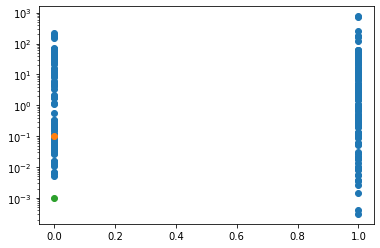

In [9]:
plt.scatter(f.minimize_ksd_variance, f.se_mean)
plt.scatter(0, 0.1)
plt.scatter(0, 0.001)
plt.yscale("log")

## Just vanilla

Clear trend for the SVGD learning rate (which is the only difference between the vanilla runs).

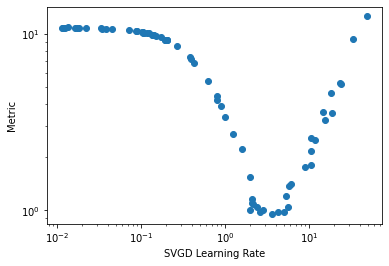

In [10]:
v = frame[f.train == False]
plt.scatter(v.lr_svgd, v.emd)
plt.xlabel("SVGD Learning Rate")
plt.ylabel("Metric")
plt.xscale("log")
plt.yscale("log")

# Vanilla + MLP

## SVGD LR
Again, a clear trend for SVGD learning rate. Not so clear for the layer sizes.

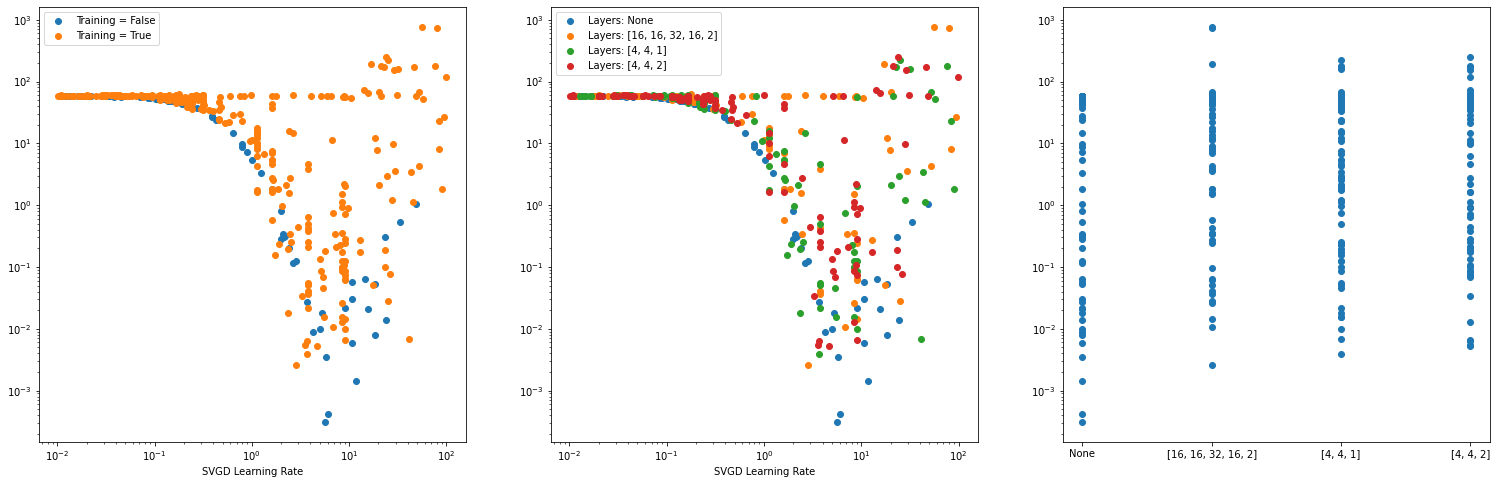

In [11]:
fig, axs = plt.subplots(1, 3, figsize=[26,8])
for ax, grouplabel, prefix in zip(axs, ("train", "encoder_layers"), ("Training = ", "Layers: ")):
    groups = f.groupby(grouplabel)
    for name, group in groups:
        ax.scatter(group.lr_svgd, group.se_mean, marker="o", label=prefix + str(name))
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend()
    _ = ax.set_xlabel("SVGD Learning Rate")

axs[2].scatter(f.encoder_layers, f.se_mean)
axs[2].set_yscale("log")

# Just MLP

In [36]:
t = f[f.train]

## Lambda
The Autoencoder regularization parameter is important:

Unfortunately, I didn't sample small enough (will fix in next run).

(0.0001, 1000.0)

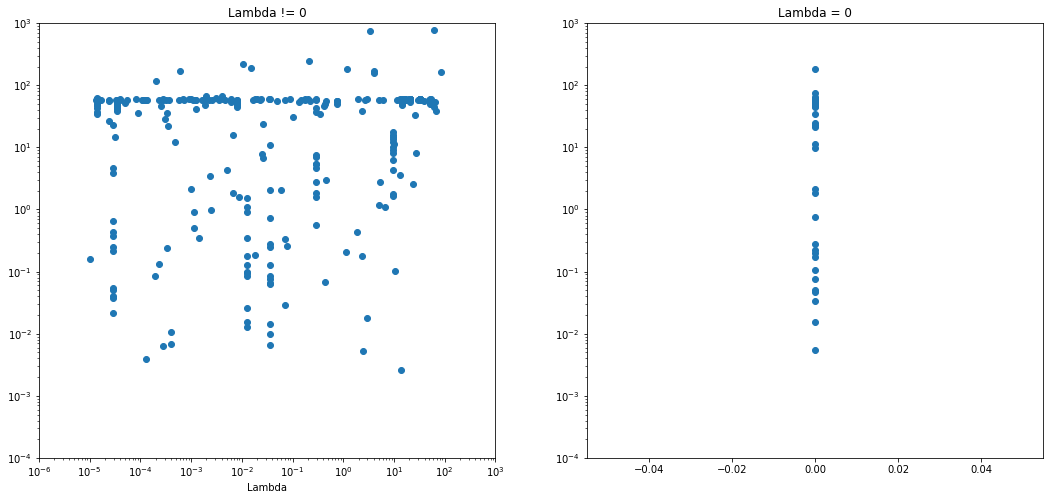

In [18]:
fig, axs = plt.subplots(1, 2, figsize=[18,8])
ax = axs[0]
ax.set_title("Lambda != 0")
ax.scatter(t.lambda_reg, t.se_mean)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-6, 1e3)
ax.set_ylim(1e-4, 1e3)
ax.set_xlabel("Lambda")

ax = axs[1]
ax.set_title("Lambda = 0")
ax.scatter(t[t.lambda_reg==0].lambda_reg, t[t.lambda_reg==0].se_mean)
ax.set_yscale("log")
ax.set_ylim(axs[0].get_ylim())

For next plots, leave out shitty unregularized results.

In [178]:
f = t[t.lambda_reg != 0]

## KSD Variance

This parameter is irrelevant

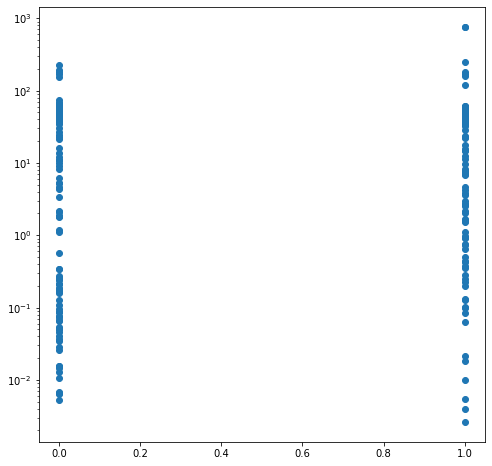

In [19]:
fig, ax = plt.subplots(figsize=[8,8])
ax.scatter(t.minimize_ksd_variance, t.se_mean)
ax.set_yscale("log")

## Encoder / decoder LR

This learning rate is also important. Tho need more data here too.

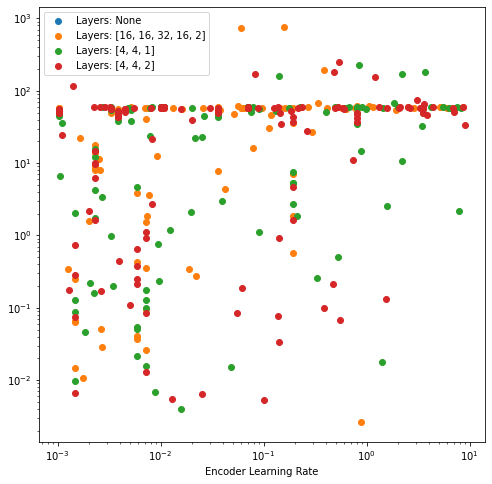

In [22]:
fig, ax = plt.subplots(figsize=[8,8])
groups = t.groupby(grouplabel)
for name, group in groups:
    ax.scatter(group.lr_ksd, group.se_mean, marker="o", label=prefix + str(name))
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
_ = ax.set_xlabel("Encoder Learning Rate")

# Rundata

In [55]:
ind = 421
f.iloc[ind]

se_mean                                                            57.9607
se_var                                                             5.77004
ksd                                                                11.0322
emd                                                                10.8624
lr_ksd                                                           0.0701779
lr_svgd                                                          0.0109199
svgd_steps                                                               1
encoder_layers                                         [16, 16, 32, 16, 2]
ksd_steps                                                               10
train                                                                 True
lambda_reg                                                         16.1868
target_args              [[6, 3], [[5.758691293044347, 2.73343154077325...
minimize_ksd_variance                                                 True
Name: 421, dtype: object

In [58]:
f[f.emd > 0].emd.min()

0.5774093270301819

In [56]:
rundata[ind].keys()

odict_keys(['Interrupted because of NaN', 'autoencoder_loss', 'decoder_params', 'encoder_params', 'is_pd', 'ksd_after_svgd_update', 'ksd_after_svgd_update_val', 'ksd_before_kernel_update', 'ksd_before_kernel_update_val', 'ksd_variance', 'ksd_variance_val', 'leader_idx', 'leader_mean', 'leader_var', 'mean_drift', 'mean_repulsion', 'particles', 'regularized_loss', 'square_errors', 'train_idx', 'training_mean', 'training_var', 'update_to_weight_ratio', 'validation_idx', 'validation_mean', 'validation_var'])

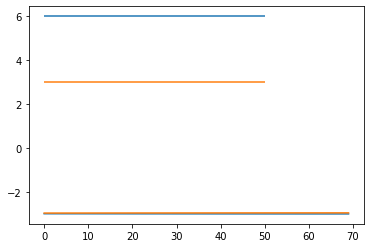

In [57]:
colorcycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
mean = onp.array(rundata[ind]["training_mean"])
tru_mean = configs[ind]["svgd"]["target_args"][0]

_ = plt.plot(mean)
_ = plt.hlines(tru_mean, 0, 50, colors=colorcycle)

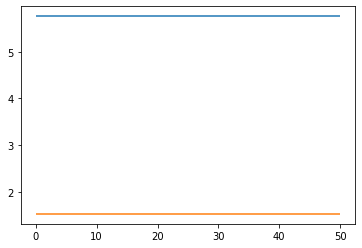

In [53]:
var = onp.array(rundata[ind]["training_var"])
tru_var = onp.diag(configs[ind]["svgd"]["target_args"][1])
_ = plt.plot(var)
_ = plt.hlines(tru_var, 0, 50, colors=colorcycle)